# DO NOT GRADE THIS HOMEWORK! I AM AUDITING THE COURSE AND THIS SUBMISSION IS ONLY UPLOADED OUT OF A WEIRD DESIRE FOR COMPLETION. 

In [235]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_classification


In [236]:
threeD = True #this parameter determines whether or not we are simulating the 3d version 
#change this to False and we automatically simulate for 2d. This is not part of the homework and should not be graded

dimensions = 3 if threeD else 2 
X, y = 0, 0
X, y = make_classification(n_samples=500, n_features=dimensions, n_informative=dimensions,
                           n_redundant=0, n_clusters_per_class=1,
                           flip_y=0.1,  # adds a small amount of noise
                           class_sep=1.0,  # classes are separable but not too easily
                           random_state=40)
w = np.random.rand(dimensions,1)
w_old = np.copy(w)

b = np.random.rand()
b_old = b


### Relabel the Y targets to +1/-1

In [237]:
y = np.where(y == 1, -1, y)
y = np.where(y == 0, 1, y)

#question. If I do not know which side is better to be labeled as -1 and +1 what should I do? Does it inherently matter?

### Split the dataset into training + testing datasets

In [238]:
#The split should aim to be 1/2 as +1 and 1/2 as -1!
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

### Soft margin SVM 

In [239]:
def give_projection(X, y, w, b): #gets the projection using the current dataset 
    N = len(y)
    
    mat_b = np.full((N, 1), b)
    mat_1 = np.full((N, 1), 1)
    mat_y = np.reshape(y, (len(y), 1))

    projection = mat_1 - mat_y * (X @ w + mat_b)
    return projection 

def SVM_loss(X, y, w, b, C): #loss of the function 
    N = len(y)
    #vec_w = np.reshape(w, (len(w),))
    margin_error = np.linalg.norm(w)**2 / 2
    
    projection = give_projection(X, y, w, b)
    
    projection[projection < 0] = 0 #achieves the same as max 0, and value 
    
    #print(projection)
    classification_error = C / N * np.sum(projection)
    
    return margin_error + classification_error 

    
def SVM_gradient_w(X, y, w, b, C): #gradient for w 
    N = len(y)
    mat_y = np.reshape(y, (len(y), 1))
    
    projection = give_projection(X, y, w, b)
    
    summation = -C * mat_y * X
    summation[(projection < 0).any(axis=1)] = 0
    

    summation = np.sum(summation, axis = 0)
    summation = summation / N 
    
    summation = np.reshape(summation, (len(summation), 1))

    return w + summation

    
def SVM_gradient_b(X, y, w, b, C): #gradient for b 
    projection = give_projection(X, y, w, b)
    grad = -C * y
    
    grad[(projection < 0).any(axis=1)] = 0
    
    return np.sum(grad)
    

#large C emphasizes minimizing the classification error
#small C emphasizes maximizing margin 
# C = 0.01

# loss = SVM_loss(X_train, y_train, w, b, C)
# grad = SVM_gradient_w(X_train, y_train, w, b, C)
# grad = SVM_gradient_b(X_train, y_train, w, b, C)

### Mini batch gradient descent + shuffle data. 
### Optimal weights + minimize loss function

In [240]:
batches = 40  #then there should be 40 of these batches. size 10 for each batch 

epochs = 250
lr = 0.0001 #learning rate 

C = 10 #how much do we care about the accuracy of classification versus margin width? 
#Increase C to make the margin harder, decrease C to make the margin softer 
loss_collection = []
epoch_collection = []

for epoch in range(epochs):
    
    # Split data into batches
    indices = np.random.permutation(len(X_train))
    X_shuffled = X_train[indices]
    y_shuffled = y_train[indices]
    
    #print(indices)
    
    X_batches = np.array_split(X_shuffled, batches)
    y_batches = np.array_split(y_shuffled, batches)
    
    for batch in range(batches):
    
        new_b = b - lr * SVM_gradient_b(X_batches[batch], y_batches[batch], w, b, C)
        new_w = w - lr * SVM_gradient_w(X_batches[batch], y_batches[batch], w, b, C)

        b = new_b
        w = new_w 

    if (epoch % 10 == 0): 
        loss = SVM_loss(X_train, y_train, w, b, C)
        loss_collection.append(loss)
        epoch_collection.append(epoch)
        print("Epoch is:", epoch, "and the loss is", loss)
        

Epoch is: 0 and the loss is 8.722478307719893
Epoch is: 10 and the loss is 4.237792003768564
Epoch is: 20 and the loss is 3.948985846975267
Epoch is: 30 and the loss is 3.8925782867442624
Epoch is: 40 and the loss is 3.8633487157067803
Epoch is: 50 and the loss is 3.8432428355045714
Epoch is: 60 and the loss is 3.8324972536367223
Epoch is: 70 and the loss is 3.8260101793551966
Epoch is: 80 and the loss is 3.8202610074859864
Epoch is: 90 and the loss is 3.8153325196018497
Epoch is: 100 and the loss is 3.8107374210695424
Epoch is: 110 and the loss is 3.8066333622924393
Epoch is: 120 and the loss is 3.803057027028929
Epoch is: 130 and the loss is 3.8001078371848256
Epoch is: 140 and the loss is 3.797487222631904
Epoch is: 150 and the loss is 3.7953320934202974
Epoch is: 160 and the loss is 3.793740536555529
Epoch is: 170 and the loss is 3.7926009807812138
Epoch is: 180 and the loss is 3.791600201150343
Epoch is: 190 and the loss is 3.7909459431961468
Epoch is: 200 and the loss is 3.790180

### Predictions on the test 

In [241]:
#the goal is simply to see what side it would be on. then to see what it actually is to get the accuracy rate 
#Accuracy calculations can be thought of as the number of values classified correctly 

def correct(X, y, w, b):
    mat_y = y.reshape(len(y), 1)
    prediction = mat_y * (X @ w + b)
    count = np.sum(prediction > 0)
    return count 

def ratio(X, y, w, b):
    number_correct = correct(X, y, w, b)
    ratio = number_correct / len(X)
    return ratio 

print("Accuracy for training data is: ", ratio(X_train, y_train, w, b))
print("Accuracy for test data is: ", ratio(X_test, y_test, w, b))

Accuracy for training data is:  0.88
Accuracy for test data is:  0.93


### Accuracy Calculations

In [242]:
print("Accuracy before training is: " , ratio(X, y, w_old, b_old))
print("Accuracy after training is: ", ratio(X, y, w, b))

Accuracy before training is:  0.578
Accuracy after training is:  0.89


### 3D visualizations 
Source: https://pythonnumericalmethods.berkeley.edu/notebooks/chapter12.02-3D-Plotting.html#:~:text=In%20order%20to%20plot%203D,3D%20plotting%20capabilities%20to%20matplotlib.&text=Once%20we%20imported%20the%20mplot3d,add%20data%20to%20the%20axes. 

**The green plane is the plane after training. The red plane is the plane without training generated at random.**

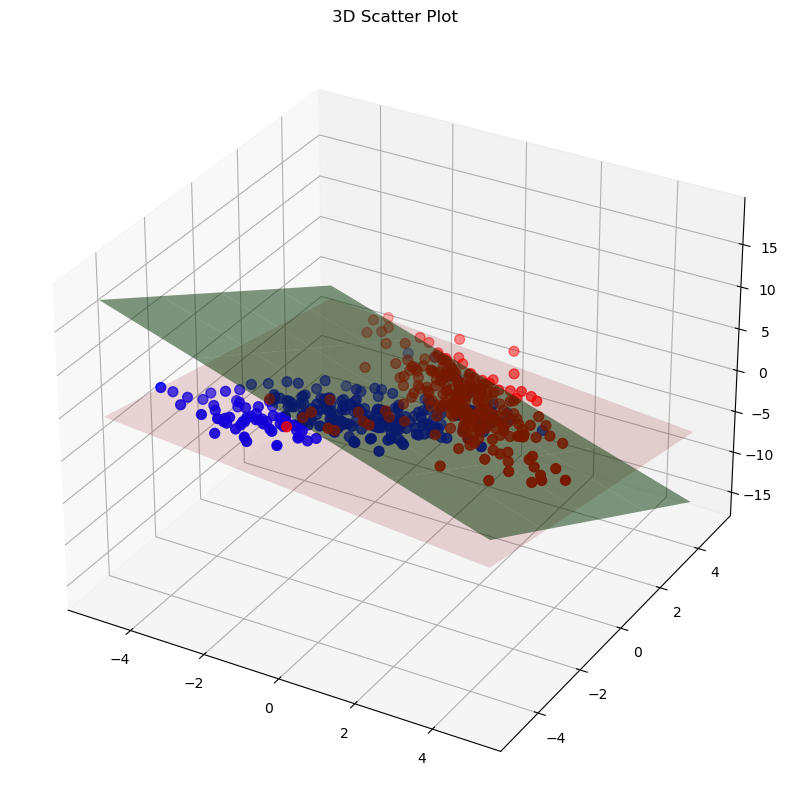

In [243]:
fig = plt.figure(figsize = (10,10))


X_true = X[y==1]
X_false = X[y==-1]

#3d visualization

if (threeD): #this contains my code for displaying the 3d version 
    ax = plt.axes(projection='3d')
    
    ax.scatter(X_true[:,0], X_true[:,1], X_true[:,2], c = 'r', s = 50)
    ax.scatter(X_false[:,0], X_false[:,1], X_false[:,2], c = 'b', s = 50)


    X_dis, Y_dis = np.meshgrid(np.linspace(-5, 5, 5), np.linspace(-5, 5, 5))
    Z_dis = (-w[0] * X_dis - w[1] * Y_dis - b) / w[2]
    ax.plot_surface(X_dis, Y_dis, Z_dis, color= 'green', alpha=0.5)
    
    
    Z_dis = (-w_old[0] * X_dis - w_old[1] * Y_dis - b_old) / w_old[2]


    ax.plot_surface(X_dis, Y_dis, Z_dis, color= 'red', alpha=0.15)

    ax.set_title('3D Scatter Plot')

else: #this contains my code for display the 2d version. This is not my project. 
    #It is solely for my own understanding
 
    plt.scatter(X_true[:,0], X_true[:,1], c = 'r', s = 50)
    plt.scatter(X_false[:,0], X_false[:,1], c = 'b', s = 50)
    
    t = np.linspace(-10, 10,100)  # Adjust the range as needed
    x = t
    y = (-b - w[0] * t)/w[1]

    # Plot the line
    plt.plot(x, y, c= 'g', label='New Line')
    
    x = t
    y = (-b_old - w_old[0] * t)/w_old[1]

    # Plot the line
    plt.plot(x, y, c= 'r', label='Old Line')
    
    
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Scatter Plot')
    

plt.show()



### Loss function visualizations

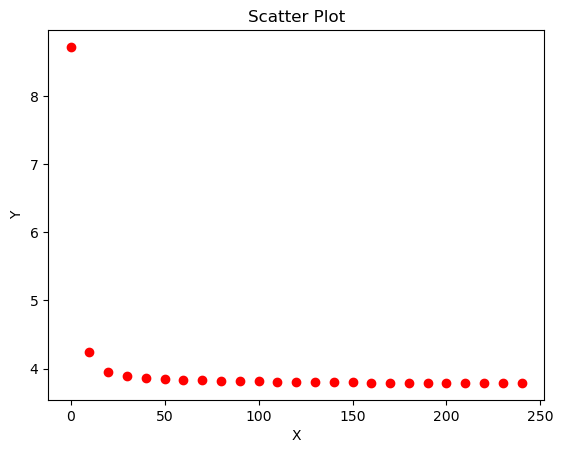

In [244]:
plt.scatter(epoch_collection, loss_collection, c='r')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter Plot')
plt.show()